In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,4)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 16

import dask.dataframe as dd
import pandas as pd
import numpy as np
import time
import warnings

import plotly.io as pio
pio.renderers.default = 'notebook'

# Table of Contents 
In order to build one's own strategies and perform backtesting in Dope, one needs to follow the steps below:

### Load Data
We will obviously need token data in order to perform the backtesting.

### Triggers
Set up the triggers, these being the timepoints at which rebalancing of the strategy occurs.

### Implement Bespoke Strategy
A simple on-workbook example of a bespoke strategy is presented.

### Perform Backtesting

# Load Data
This code loads the token data from DeFiLlama

In [2]:
from dope.backengine.maestro import BackEngineMaestro
maestro = BackEngineMaestro()

In [3]:
pool_urls = """
#USDT
https://defillama.com/yields/pool/f981a304-bb6c-45b8-b0c5-fd2f515ad23a
https://defillama.com/yields/pool/4e8cc592-c8d5-4824-8155-128ba521e903
https://defillama.com/yields/pool/60d657c9-5f63-4771-a85b-2cf8d507ec00
https://defillama.com/yields/pool/c037a916-a462-4c65-b217-100db0fdc0e0
https://defillama.com/yields/pool/57647093-2868-4e65-97ab-9cae8ec74e7d
https://defillama.com/yields/pool/043a8330-bc29-4164-aa1c-28de7bf87755
https://defillama.com/yields/pool/4cecbdfa-7189-4801-88ef-cdfee4b23298
https://defillama.com/yields/pool/a3a5cf89-9a9e-4db7-8f6d-1af3d5714d79
https://defillama.com/yields/pool/4ce0c458-2171-463b-92ce-458afe367a4e
https://defillama.com/yields/pool/edaefc40-d818-48bd-a87a-d9c87598c1bc
https://defillama.com/yields/pool/1350803f-262c-4c7e-b134-d2f693c7a7c8
https://defillama.com/yields/pool/c88d4008-f567-44e6-8ac8-a56d4f765a62
https://defillama.com/yields/pool/e43ddfa2-5e6b-40b2-ae74-d01e1a1c10b8
https://defillama.com/yields/pool/612af285-321a-4295-8362-59a6113da145
"""

pool_ids = [url.split("/")[-1] for url in pool_urls.split("\n") if "defillama.com" in url]

token = 'USDT'

data, run_data = maestro.load_defilama_with_token_pool_id(
  token_pool_id_dict = {  token: pool_ids },
  start_period="2024-05-01"
)

USDT
Ethereum:aave-v3:USDT f981a304-bb6c-45b8-b0c5-fd2f515ad23a 155 155
Ethereum:fluid:USDT 4e8cc592-c8d5-4824-8155-128ba521e903 126 126
Ethereum:compound-v2:USDT 57647093-2868-4e65-97ab-9cae8ec74e7d 155 155
Ethereum:morpho-blue(LTV 86%):WBTC-USDT c037a916-a462-4c65-b217-100db0fdc0e0 153 153
Ethereum:aave-v2:USDT 60d657c9-5f63-4771-a85b-2cf8d507ec00 155 155
Ethereum:morpho-blue(LTV 86%):WSTETH-USDT 4ce0c458-2171-463b-92ce-458afe367a4e 153 153
Ethereum:morpho-blue(LTV 100%):BBUSDT 043a8330-bc29-4164-aa1c-28de7bf87755 126 126
Ethereum:morpho-blue(LTV 100%):GTUSDT 4cecbdfa-7189-4801-88ef-cdfee4b23298 126 126
Ethereum:morpho-blue(LTV 91.5%):SUSDE-USDT a3a5cf89-9a9e-4db7-8f6d-1af3d5714d79 153 153
Ethereum:morpho-blue(LTV 100%):RE7USDT 1350803f-262c-4c7e-b134-d2f693c7a7c8 126 126
Ethereum:gearbox:USDT edaefc40-d818-48bd-a87a-d9c87598c1bc 155 155
Ethereum:morpho-blue(LTV 91.5%):USDE-USDT c88d4008-f567-44e6-8ac8-a56d4f765a62 153 153
Ethereum:morpho-blue(LTV 86%):WSTETH-USDT e43ddfa2-5e6b-40b2-

# Triggers
This code sets up daily triggers, corresponding to daily rebalancing

In [4]:
daily_triggers = {}
daily_triggers[token] = run_data.to_block(token).utilizationRate.resample("1D").last().index
print(token, len(daily_triggers[token]))

USDT 155


# Implement Bespoke Strategy
We illustrate with a naive strategy example, which just randomly selects at each rebalancing time one of the $N$ protocols, each with $P(\omega_i)=1/N$. The on_act() method returns a weight $w_i=1$ for the randomly selected protocol $\omega_i$. Zero weights for the other protocols are implicit and do not need to be specified.

In [5]:
from dope.backengine.agents.base import BaseAgent

class BespokeStrategy(BaseAgent):
  def __init__(self, token, capital, seed=42, triggers=None):
    self.token = token
    self.seed = seed
    self.capital = capital
    self.triggers = triggers
    self.engine = None
    self.ws = {}
    np.random.seed(self.seed)
  
  def on_act(self, date_ix):
    if self.triggers is not None:
      if date_ix not in self.triggers:
        return self.ws
      
    selected_protocol = np.random.choice(list(self.data[token].keys()))
    ws = {} 
    ws[selected_protocol] = 1
    self.ws = {self.token:ws}
    return self.ws

# Perform Backtesting

In [6]:
summaries = {}
CAPITAL = 2_000_000

In [7]:
from dope.backengine.arbengine import ArbBacktester

bt_name ="daily rebalance"
strategy = BespokeStrategy(token=token, capital=CAPITAL, seed=42, triggers=daily_triggers[token])
strategy.verbose = False
arbt = ArbBacktester(strategy=strategy, borrow_lend_data=run_data, 
                     data=run_data)
print(bt_name)
summaries[bt_name], _ = arbt(start_timestamp='2024-06-01')

daily rebalance
Running Backtest for 155 | token:USDT


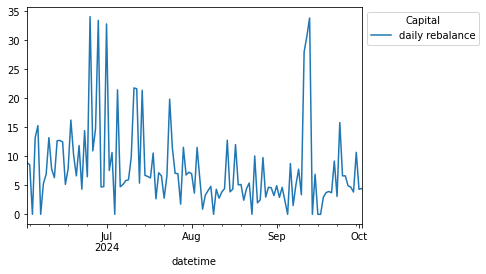

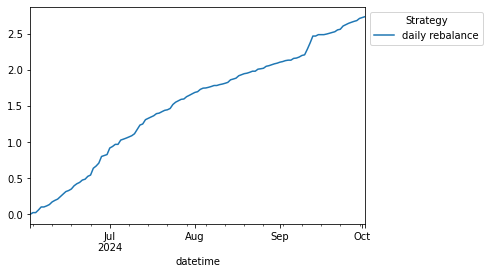

In [8]:
_summaries = {k:summaries[k].dropna() for k in summaries.keys()}
summary = pd.concat(_summaries, names=["datetime"]).unstack(level=0).dropna()

summary.rate.plot()
_ = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Capital")
plt.show()

((summary.capital/summary.capital.iloc[0] - 1)*100).plot()
_ = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Strategy")
plt.show()
